#Facebook Prophet 
Познакомимся с библиотекой для прогнозирования временных рядов (в переводе с английского, "пророк", выпущена в open-source 23-го февраля 2017 года.

Согласно статье Facebook Prophet, был разработан для прогнозирования большого числа различных бизнес-показателей и строит достаточно хорошие default'ные прогнозы. Кроме того, библиотека дает возможность, изменяя человеко-понятные параметры, улучшать прогноз и не требует от аналитиков глубоких знаний устройства предсказательных моделей.

#Сравнение mean absolute percentage error#
для различных методов автоматического прогнозирования временных рядов, согласно которому Prophet имеет существенно более низкую ошибку.

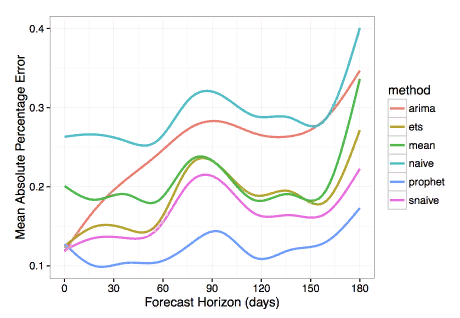

#Рассмотрим пример тестового задания в компанию Мвидео
Тестовый файл sales_and_features.csv содержит продажи и признаками, с помощью которых
нужно предсказать продажи как целевую переменную.

Описание к колонкам:
Sales_size  – продажи
Date – дата
feature_* - признаки 
 
Что мы ждем от кандидата:
Jupyter ноутбук в котором проведено исследование:
- Как сезонность влияет на продаежи.
- Какие признаки влияют на продажи. Можно ли с помощью признаков и сезонности
предсказать продажи на неделю?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
cf.go_offline()
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

from itertools import combinations
from scipy.stats import ttest_ind

from pandas_profiling import ProfileReport
from fbprophet import Prophet

plt.rcParams['figure.figsize'] = [18.0, 10.0]
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'


In [ ]:
init_notebook_mode(connected=False)
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
  

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
https://drive.google.com/file/d/1mlKuchGDEk2jQAtXdU-DaxYw9s8ttMWO/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

dir_data = './drive/MyDrive/SF/SF Webinars/Временные ряды/'
data = pd.read_csv(dir_data+'sales_and_features.csv')

data['Date'] = pd.to_datetime(data.Date)
df = data.copy()
df.head()

Mounted at /content/drive


,Date,Sales_size,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,2015-01-01,4.013723,151976,136,0,0,15663,0,0,0,661,0
1,2015-01-02,7.220396,204223,185,0,0,20075,0,0,0,5404,0
2,2015-01-03,8.195494,158073,146,0,0,11251,0,0,0,1103,0
3,2015-01-04,7.637879,161828,146,0,0,14118,0,0,0,1213,0
4,2015-01-05,5.982856,241127,209,0,0,644286,0,0,676,78757,0


In [ ]:
# посмотрим на данные
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title='Pandas Profiling Report')


**Видим в данных много нулевых значений, пропущенных значений нет, данные по дням, сильную корреляцию между признаками feature_1 - feature_2 и feature_5 - feature_9, далее будем использовать один из двух признаков**

**Так как у нас много категориальных признаков, посмотрим на них отдельно и проведем оценку на стат.значимость.**

In [ ]:
def get_boxplot(column):
    """Возвращает boxplot"""
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='Sales_size',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:30])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    

In [ ]:
def get_stat_dif(column):
    """функция проверки статистических различий для значений признака"""
    cols = df.loc[:, column].value_counts().index[:30]
    combinations_all = list(combinations(cols, 2))
    
    # Рассматривается статистическая связь между каждыми двумя признаками, то значениями в каждой паре
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'Sales_size'], 
                     df.loc[df.loc[:, column] == comb[1], 'Sales_size'],
                    nan_policy='omit').pvalue\
            <= 0.05/len(combinations_all): # Поправка Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

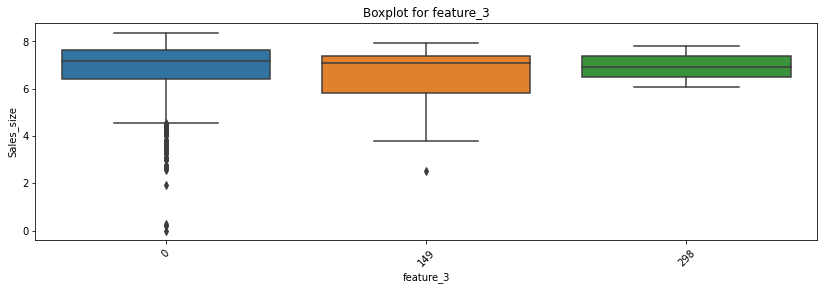

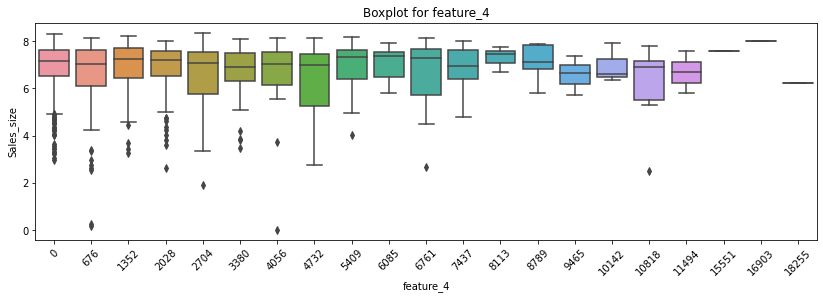

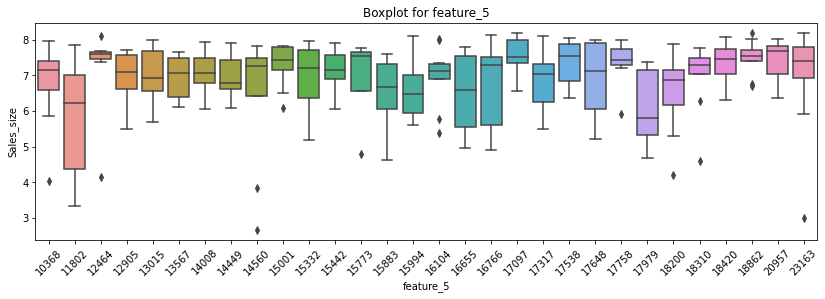

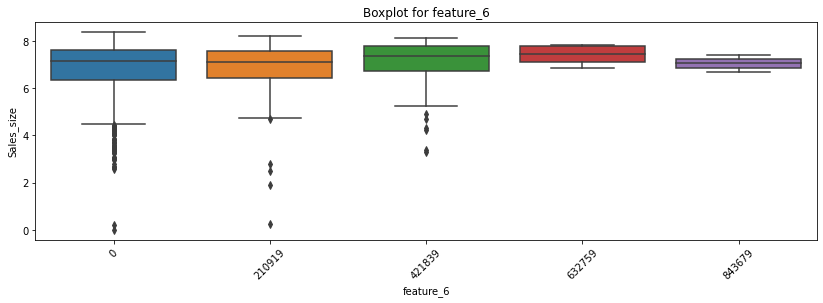

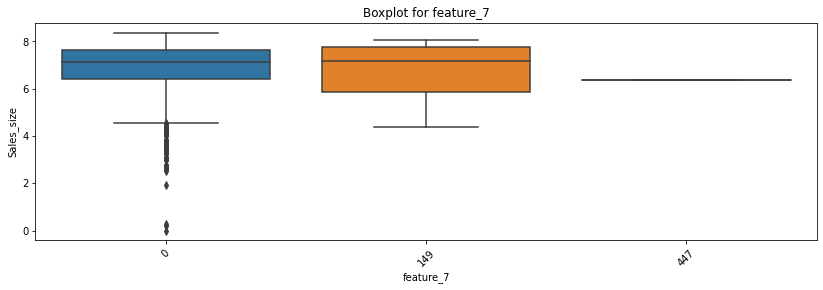

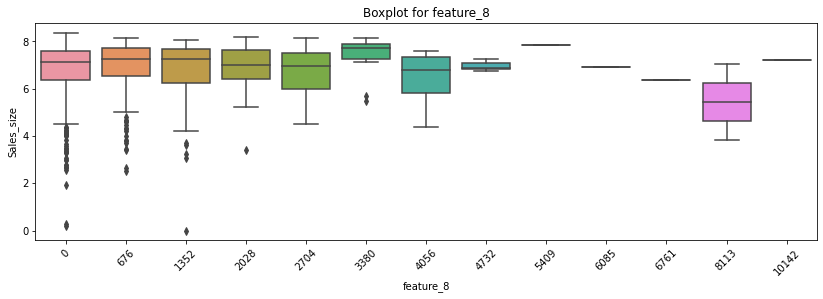

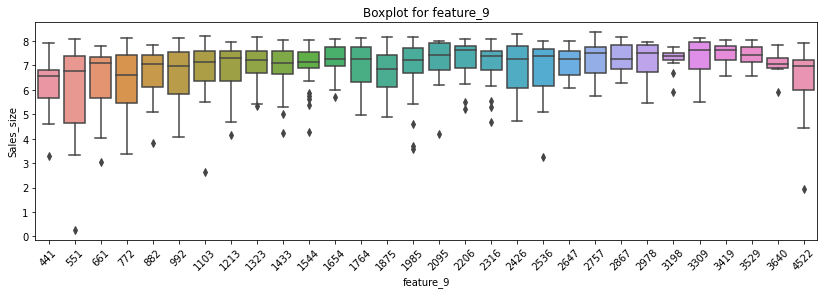

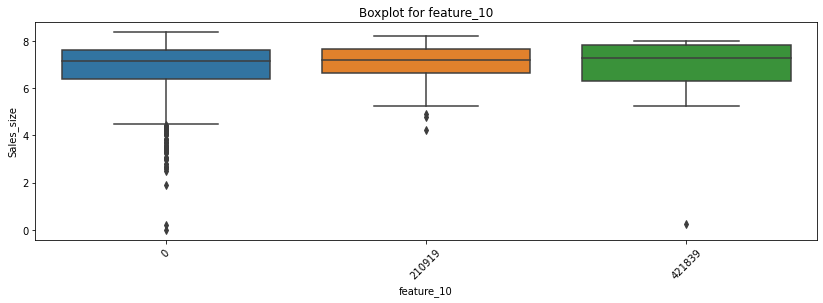

In [ ]:
col = ['feature_3', 'feature_4','feature_5',
       'feature_6', 'feature_7','feature_8','feature_9','feature_10']
for i in col:
    get_boxplot(i) 
   

**Уже по графикам видно, что признаки не оказывают значимого влияния на продажи, за исключением, признака "feature_9"
Проведем еще Тест-Стьюдента**

In [ ]:
for i in col:
    get_stat_dif(i)

Найдены статистически значимые различия для колонки feature_9


**Догадки подтвердились.**

**Итого, согласно проведенному анализу, для дальнейшего постороения модели следует использовать признаки feature_9 и feature_1. 
**

## Посмотрим на наш временной ряд

In [ ]:
configure_plotly_browser_state()
df = data.set_index('Date')
sale = df['Sales_size']
sale.iplot(title= 'Временной ряд по продажам с 2015-01-01 по 2017-12-31')

**Понизим разрешение данных до недели, для большей наглядности**

In [ ]:
configure_plotly_browser_state()
sale_w = sale.resample('w').sum()
sale_w.iplot(title= 'Временной ряд по продажам с 2015-01-01 по 2017-12-31 по неделям')

**Так уже видно некоторые закономерности, но разложим наш ряд на тренд, сезонность и остатки.**

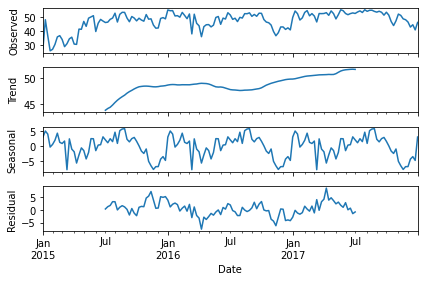

In [ ]:
decomposition = seasonal_decompose(sale_w, model='additive') 
decomposition.plot()
plt.show() 

**Изобразим тренд и сезонность по отдельности**

In [ ]:
trend_part = decomposition.trend # отдельно трендовая составляющаяя
seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
# residual_part = decomposition.resid # отдельно шум: то, что осталось

In [ ]:
configure_plotly_browser_state()
trend_part.iplot(title= 'Тренд')

**Тренд возрастающий, следовательно, продажи растут, это хорошо!**

In [ ]:
configure_plotly_browser_state()
seasonal_part.iplot(title= 'Сезонность')

**Видим типичную ситуацию для ритейла: Март, Ноябрь(не зря же придумали "Черную пятницу")  - продажи сильно проседают; Январь, Август - взлетают.**

## Попробуем предсказать наши продажи

In [ ]:
train_col = ['Date','Sales_size']
ds=data[train_col]
ds.columns = ['ds', 'y']

In [ ]:
from fbprophet import Prophet

# Период, который ,будем предсказать (проверка модели)
predictions = 300
train_df = ds[:-predictions]
# строим модель
m = Prophet(daily_seasonality=False,weekly_seasonality=True,
            yearly_seasonality=True)
m.fit(train_df)
# Смотрим, что предсказалось
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)
m.plot(forecast)

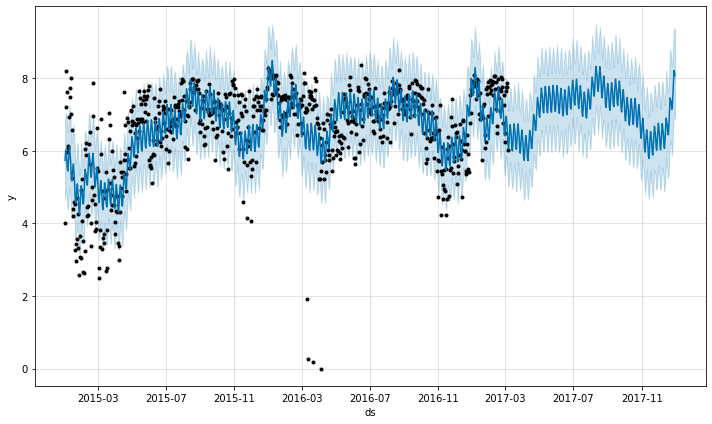

In [ ]:
# Смотрим, что предсказалось
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)
m.plot(forecast);

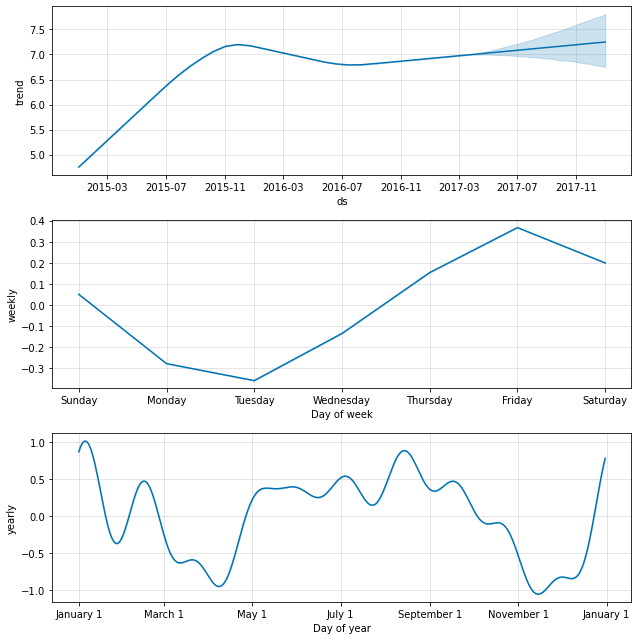

In [ ]:
# Смотрим на сезонности и тернд
m.plot_components(forecast);

**Наши предыдушие выводы подтверждаются, но по этим графикам более наглядно видно как годовую сезонность, так и недельную: продажи падают в начале недели и возрастают в конце.**

In [ ]:
# посмотрим на прогноз более детально
configure_plotly_browser_state()
iplot([
    go.Scatter(x=ds['ds'], y=ds['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [ ]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(ds.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  8.90453005747474 %
MAE (средняя абсолютная ошибка) –  0.6355210375764732


**MAPE 9%, думаю несильно плохой результат, но попробуем улучшить модель, добавив признак feature_1**

In [ ]:
data_with_regressors = ds
data_with_regressors['feature_1'] = data['feature_1']
m2 = Prophet( daily_seasonality=False,weekly_seasonality=True, yearly_seasonality=True)
data_train = data_with_regressors[:-predictions]
data_test = data_with_regressors[-predictions:]
m2.add_regressor('feature_1')
m2.fit(data_train)
future = m2.make_future_dataframe(periods=predictions)

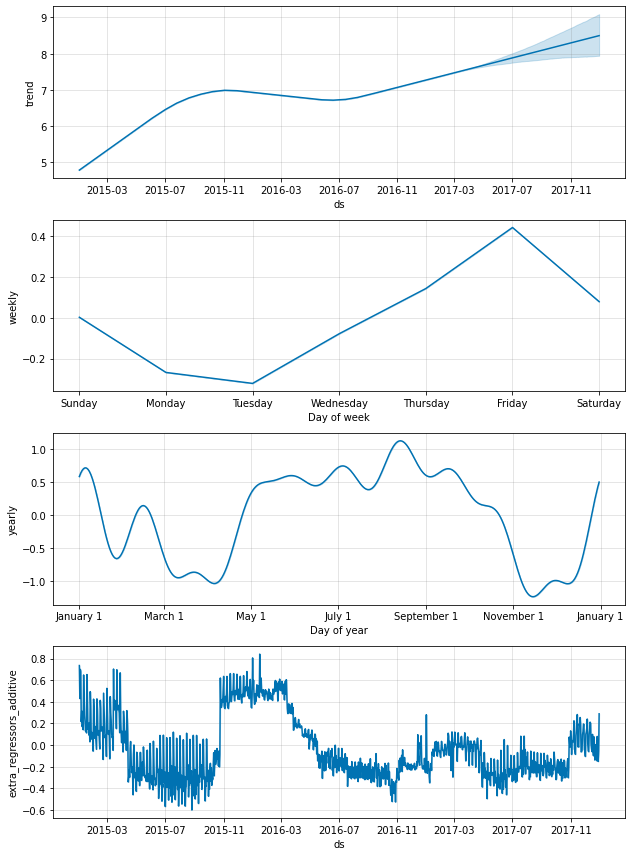

In [ ]:
futures = future
futures['feature_1'] = data_with_regressors['feature_1']
forecast = m2.predict(futures)
m2=m2.plot_components(forecast)

In [ ]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(data_with_regressors.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  12.11133049149443 %
MAE (средняя абсолютная ошибка) –  0.8330626079903507


**Признак feature_1 отрицательно повлиял на качество модели, поэтому прогноз на неделю будем строить без него.**

## Спрогнозируем на неделю вперед

In [ ]:
prediction_days = 7
final_train_df = ds
f = Prophet( daily_seasonality=False,weekly_seasonality=True, yearly_seasonality=True)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

In [ ]:
# Рисуем график с границами прогноза на полном периоде
configure_plotly_browser_state()
iplot([
    go.Scatter(x=ds['ds'], y=ds['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='prediction'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

**Прогноз на неделю выглядит правдаподобно, но, возможно, немного завышен.**

## Итог:
**В данном ноутбуке было проведено исследование и получены ответы на следующие вопросы: **

- Как сезонность влияет на продажи?
-- Сезонность как годовая, так и недельная оказывает сильное влияние на продажи. Подробнее о периодах сезонности можно увидеть на графиках выше.

- Какие признаки влияют на продажи?
-- Было выявлено всего два наиболее влияющих признака feature_1 и feature_9, но они не позволили улучшить модель, поэтому прогноз строился без них.

- Можно ли с помощью признаков и сезонности предсказать продажи на неделю? 
-- Да, и достаточно не плохо.


# Что можно сделать еще?
- Использовать ансамблевые методы (CatBoost,RandomForest, XGBoost, LightGBM) и обучится на всех признаках (дату передать, как категориальные признаки:день недели, месяц; можно попробовать искуственно завысить и занизить значения дня и месяцам, где продажи ниже/выше, таким образом учесть сезонность, если модель не увидит эту закономерность сама.
- Использовать нейронные сети;
